### Student Information
Name: 黃為翰

Student ID: 113065508

GitHub ID: hhhwei23

Kaggle name: HHuang065508

Kaggle private scoreboard snapshot:

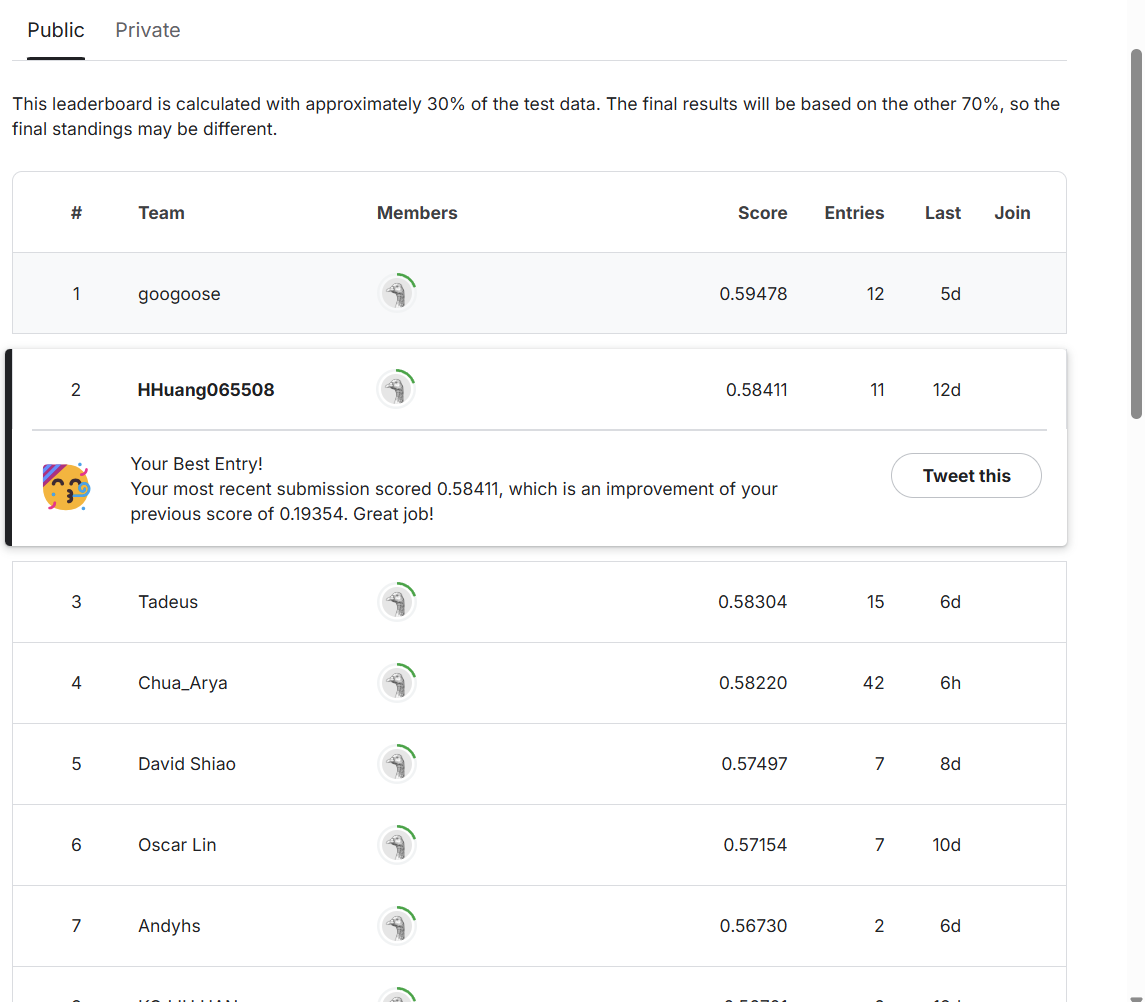

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [1]:
### Begin Assignment Here

# Load in the data

### Need to use GPU for training (RTX4060 Ti)

In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import BertweetTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import get_scheduler
from tqdm import tqdm

### Load data

In [2]:
# Environment = 1 # Kaggle
Environment = 2 # Local

if Environment == 1:
    folder_name = '/kaggle/input/dm-2024-isa-5810-lab-2-homework'
elif Environment == 2:
    folder_name = 'dm-2024-isa-5810-lab-2-homework'

"""Load data from local or Kaggle"""
#===========================================================================
data_identification = pd.read_csv(folder_name + '/data_identification.csv')
emotion = pd.read_csv(folder_name + '/emotion.csv')
sample_submission = pd.read_csv(folder_name + '/sampleSubmission.csv')
df_twitter = pd.read_json(folder_name + '/tweets_DM.json', lines=True)

### Seperate ids of training and testing dataset

In [3]:
train_ids_df = data_identification[data_identification['identification'] == 'train'].drop(['identification'], axis=1)
test_ids_df = data_identification[data_identification['identification'] == 'test'].drop(['identification'], axis=1)

In [4]:
train_ids_df.head()

,tweet_id
1,0x29e452
2,0x2b3819
4,0x2a2acc
5,0x2a8830
6,0x20b21d


### Process the json file (tweet)

use 'json_normalize' on _source can saperate hashtags, tweet_id and text

In [5]:
df_twitter_expanded = pd.json_normalize(df_twitter['_source'])

df_twitter = df_twitter.drop(['_source'], axis=1)
df_twitter = pd.concat([df_twitter, df_twitter_expanded], axis=1)

In [6]:
df_twitter.head()

,_score,_index,_crawldate,_type,tweet.hashtags,tweet.tweet_id,tweet.text
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s..."


### Seperate df_twitter dataset into training and testing dataset

Use train_ids_df and test_ids_df above merge df_twitter and emotion

In [7]:
df_training = pd.merge(train_ids_df, emotion, on='tweet_id', how='inner')
df_training = pd.merge(df_training, df_twitter, left_on='tweet_id', right_on='tweet.tweet_id', how='inner')

df_test = pd.merge(test_ids_df, df_twitter, left_on='tweet_id', right_on='tweet.tweet_id', how='inner')

In [9]:
df_training.head()

,tweet_id,emotion,_score,_index,_crawldate,_type,tweet.hashtags,tweet.tweet_id,tweet.text
0,0x29e452,joy,809,hashtag_tweets,2015-01-17 03:07:03,tweets,[],0x29e452,Huge Respect🖒 @JohnnyVegasReal talking about l...
1,0x2b3819,joy,808,hashtag_tweets,2016-07-02 09:34:06,tweets,"[spateradio, app]",0x2b3819,Yoooo we hit all our monthly goals with the ne...
2,0x2a2acc,trust,16,hashtag_tweets,2016-08-15 18:18:39,tweets,[],0x2a2acc,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
3,0x2a8830,joy,768,hashtag_tweets,2017-02-11 08:49:46,tweets,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",0x2a8830,Come join @ambushman27 on #PUBG while he striv...
4,0x20b21d,anticipation,70,hashtag_tweets,2016-11-23 05:37:10,tweets,"[strength, bones, God]",0x20b21d,@fanshixieen2014 Blessings!My #strength little...


# Label Encoder
### Turn label to numeric
The label is now in text, we need to turn it to numeric to use in classification

In [12]:
# Encode labels
label_encoder = LabelEncoder()
df_training['emotion_label'] = label_encoder.fit_transform(df_training['emotion'])
num_classes = len(label_encoder.classes_)

print(num_classes)

8


Show the corresponding labels

In [13]:
for idx, emotion in enumerate(label_encoder.classes_):
    print(f"Label {idx}: '{emotion}'")


Label 0: 'anger'
Label 1: 'anticipation'
Label 2: 'disgust'
Label 3: 'fear'
Label 4: 'joy'
Label 5: 'sadness'
Label 6: 'surprise'
Label 7: 'trust'


# Tokenize
### BERTweet
I use BERTweet to tokenize (BERTweet if pre-trained for English tweet)

Reference: [BERTweet: A pre-trained language model for English Tweets](<https://github.com/VinAIResearch/BERTweet>)

In [14]:
tokenizer = BertweetTokenizer.from_pretrained("vinai/bertweet-base", normalization=True) # base --> max_len = 128

Set some hyperparameters

In [ ]:
# Hyperparameters
max_len = 128
batch_size = 16
epochs = 3
learning_rate = 2e-5

Use class TweetDataset() to get the get token we need to use
__getitem__() can catch the input_ids, attention_maskm and label of each data (token)

Example:
```python
input_ids = [101, 146, 1157, 3415, 102, 0, 0, 0, ...]
attention_mask = [1, 1, 1, 1, 1, 0, 0, 0, ...]
label = 1
```

[Reference](<https://colab.research.google.com/github/devhemza/BERTweet_sentiment_analysis/blob/main/BERTweet.ipynb#scrollTo=klREKd8HKX9C>)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

Split to training and validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_training['tweet.text'],
                                                  df_training['emotion_label'],
                                                  test_size=0.2,
                                                  random_state=1111)

Use DataLoader in ```torch.utils.data``` to load data
* Saperate dataset into batches, help model trainig

* ```traing_loader```: train data loader.
* ```batch_size```: return a batch of data with the size
* ```shuffle```: enable shuffle (true/false)

In [ ]:
# Prepare data loaders
train_dataset = TweetDataset(X_train, y_train, tokenizer, max_len)
val_dataset = TweetDataset(X_val, y_val, tokenizer, max_len)

test_dataset = TweetDataset(df_test['tweet.text'], [0] * len(df_test), tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

* AdamW optimizer is suit for transformer model
* Set Scheduler

* AutoModelForSequenceClassification is the model on Hugging Face, provide a high level API for transformer pre-trained model ```BERT, RoBERTa, BERTweet ......```

* criterion is to calculate Loss

[Reference](<https://colab.research.google.com/github/devhemza/BERTweet_sentiment_analysis/blob/main/BERTweet.ipynb#scrollTo=w7uEvVHsVuMo>)

In [ ]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",
    num_labels=num_classes
)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)
criterion = nn.CrossEntropyLoss()

In [ ]:
model.to(device)

* ```model.train()``` : Training mode
* ```for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):```：use tpdm to create process bar, travese the training data ```DataLoader(train_loader)```
* Put input_ids, attention_mask, labels to GPU
* ```optimizer.zero_grad()``` ：delete grad of prevous batch
* ```outputs = model(input_ids, attention_mask=attention_mask)``` : input_ids and attention_mask is input of model (foward pass)
* calculate logits, loss
* ```optimizer.step()```: performing gradient descent
* ```scheduler.step()```: update learning rate
* caculate training accuracy

Evaluation step is similar to training step

```model.eval()```: Evaluation mode

In [ ]:
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_correct += (logits.argmax(1) == labels).sum().item()

    train_accuracy = train_correct / len(train_dataset)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_loss += loss.item()
            val_correct += (logits.argmax(1) == labels).sum().item()
            all_preds.extend(logits.argmax(1).cpu().numpy())

    val_accuracy = val_correct / len(val_dataset)

    print(f"Epoch {epoch+1}:")
    print(f"  Training  - Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"  Validation - Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}")

torch.save(model.state_dict(), "bertweet_emotion_model.pth")
print("Model saved as bertweet_emotion_model.pth")

```Because I run the training part on other jupyter notebook, so I copy the result from that notebook```

Training Epoch 1: 100%|██████████| 72779/72779 [2:57:27<00:00,  6.84it/s]  

Epoch 1:
* Training  - Loss: 1.0313, Accuracy: 0.6263
* Validation - Loss: 0.8746, Accuracy: 0.6817

Training Epoch 2: 100%|██████████| 72779/72779 [2:54:59<00:00,  6.93it/s]  

Epoch 2:
* Training  - Loss: 0.7832, Accuracy: 0.7162
* Validation - Loss: 0.8442, Accuracy: 0.6978
  
Training Epoch 3: 100%|██████████| 72779/72779 [2:58:15<00:00,  6.80it/s]  

Epoch 3:
* Training  - Loss: 0.6575, Accuracy: 0.7619
* Validation - Loss: 0.8712, Accuracy: 0.7004
Model saved as bertweet_emotion_model.pth


Following is screenshot

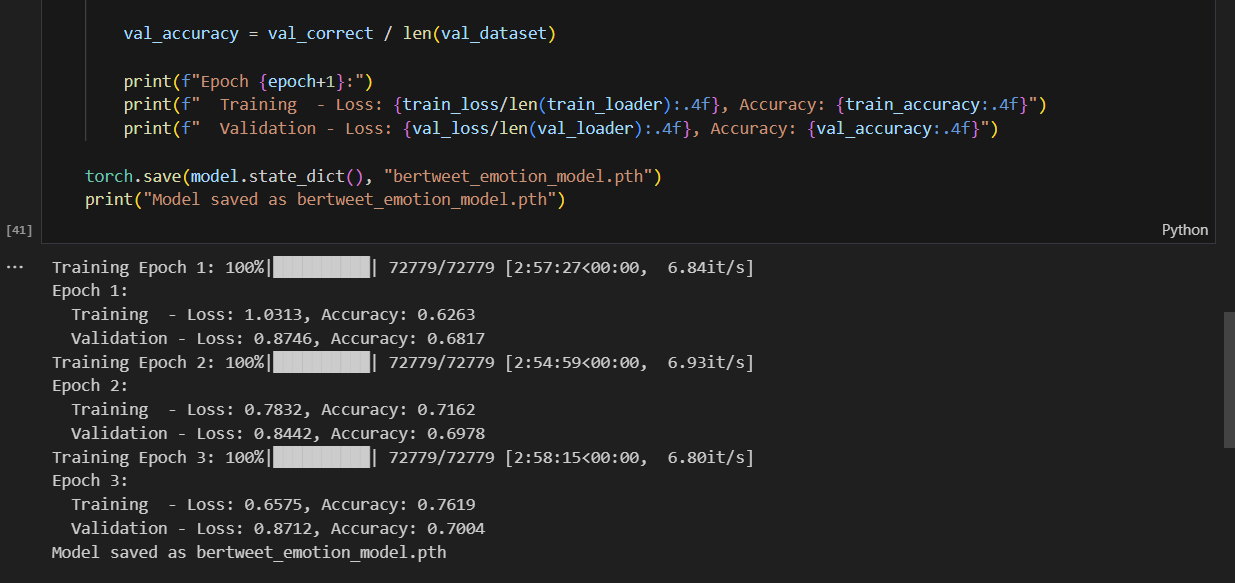

# Classification from model

I saved my model as bertweet_emotion_mode.pth after training

I need to load the model first and do testing class classification.

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",
    num_labels=num_classes
)
model.load_state_dict(torch.load("bertweet_emotion_model.pth"))
model.to(device)
model.eval()  # set to evaluation mode
print("Model loaded and ready for prediction.")

Create a new TestTweetDataset (without label)

In [ ]:
class TestTweetDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = list(texts)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0)
        }

In [ ]:
test_dataset = TestTweetDataset(texts=df_test['tweet.text'], tokenizer=tokenizer, max_len=max_len)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Prediction

In [ ]:
# Predict on test set
test_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        test_preds.extend(logits.argmax(1).cpu().numpy())

# Convert predictions back to emotions
df_test['emotion'] = label_encoder.inverse_transform(test_preds)

submission = df_test[['tweet_id', 'emotion']]
submission = submission.rename(columns={'tweet_id': 'id'})

submission.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")

Save the result (following is screenshot of prediction)

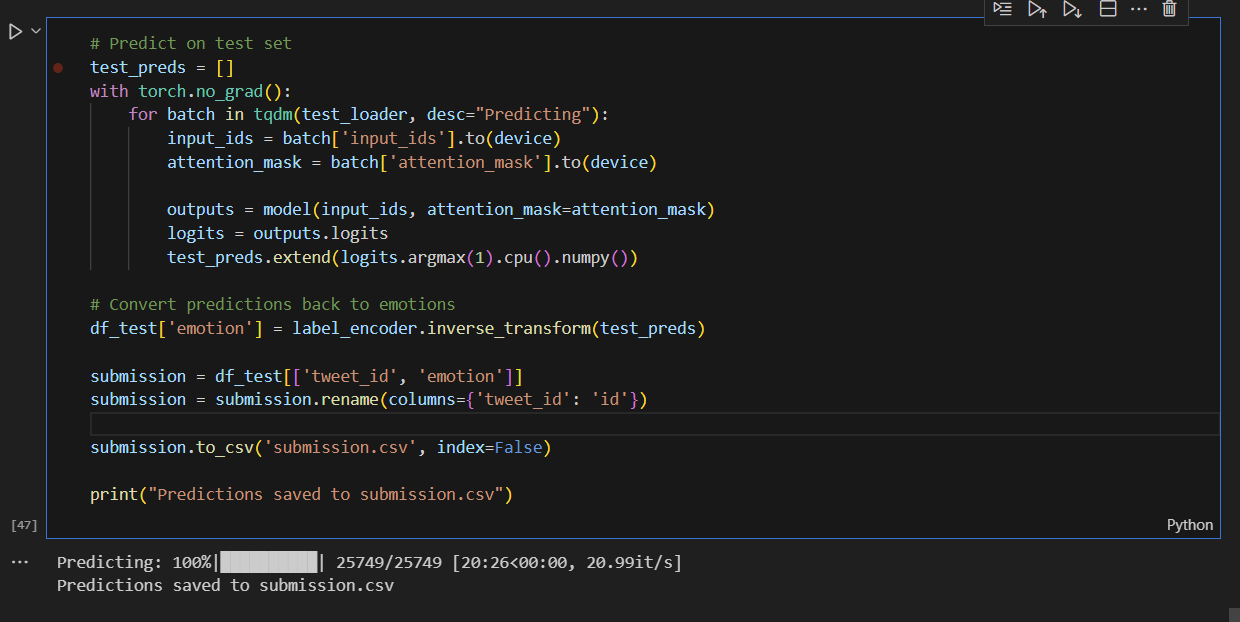

# Other Method I tried

I try several method, including BERT, Bag of word with 3000 features + Neuron network (1024 nodes)

==============================================

When I use NN in 1024 nodes, the overfitting problem occured. I used 25 epochs, the accuracy in training dataset is becoming higher and higher (from 0.56 -> 0.89). But, in validation dataset, the accuracy is decreasing (0.58->0.65->0.4). It is obviously that overfitting problem occured. (because there are too many nodes in layers)

Another problem I meet is in my preprocessing step:

originally, my preprocessing is like below:
``` python
df_twitter = pd.read_json(folder_name + '/tweets_DM.json', lines=True)
train_ids = data_identification[data_identification['identification'] == 'train']['tweet_id'].tolist()
test_ids = data_identification[data_identification['identification'] == 'test']['tweet_id'].tolist()

df_twitter_expanded = pd.json_normalize(df_twitter['_source'])

df_twitter['tweet_id'] = df_twitter_expanded['tweet.tweet_id']
df_twitter['text'] = df_twitter_expanded['tweet.text']
df_twitter['hash_tags'] = df_twitter_expanded['tweet.hashtags']

df_twitter_train = df_twitter[df_twitter['tweet_id'].isin(train_ids)]
df_twitter_test = df_twitter[df_twitter['tweet_id'].isin(test_ids)]

df_twitter_train = pd.merge(df_twitter_train, emotion, on='tweet_id', how='left')
```

But I realize that using this method (my id and text are seperated) may cause some "mismatch" problem
    --> My model's performance is very low becouse of the wrong id and wrong labels

```So I change my preprocessing method as below```

```python
train_ids_df = data_identification[data_identification['identification'] == 'train'].drop(['identification'], axis=1)
test_ids_df = data_identification[data_identification['identification'] == 'test'].drop(['identification'], axis=1)

df_twitter_expanded = pd.json_normalize(df_twitter['_source'])

df_twitter = df_twitter.drop(['_source'], axis=1)
df_twitter = pd.concat([df_twitter, df_twitter_expanded], axis=1)

df_training = pd.merge(train_ids_df, emotion, on='tweet_id', how='inner')
df_training = pd.merge(df_training, df_twitter, left_on='tweet_id', right_on='tweet.tweet_id', how='inner')

df_test = pd.merge(test_ids_df, df_twitter, left_on='tweet_id', right_on='tweet.tweet_id', how='inner')
```

I merge the ids and emotions before saperate to training and test dataset, so that the mismatch problem won't occur.

==================================================

# Things that I found

```During this Lab, I realize that data preprocessing step is really important.```'
I waste lots of time trying many tokenization and classification method, but the largest problem is base on my preprocessing step.
So if I have other chance to do such a project, I will do model building and learning after I'm sure that my preprocessing steps are all right.

This project inspired me a lot.

#### Folder ```Previous work``` includes all my previous attempts.